In [1]:
import os
from plot_goodput import read_data, plot_goodput_vs_slo

def run_and_plot(exp_name):
    os.system(f"python run_goodput_experiments.py {exp_name}")
    # print(os.popen(f'python run_goodput_experiments.py {exp_name}').read())
    result_file = f"res_{exp_name}.tsv"
    result_plot = f"fig_{exp_name}.pdf"
    data = read_data(result_file)
    plot_goodput_vs_slo(data, result_plot, True)

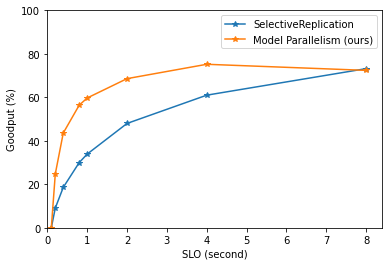

Output the plot to fig_gamma_2.pdf


In [2]:
run_and_plot("gamma_2")

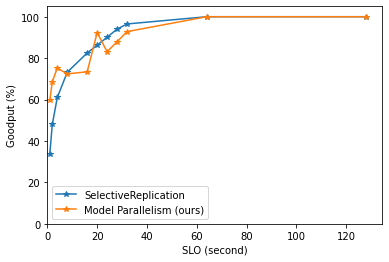

Output the plot to fig_gamma_2_long_slos.pdf


In [3]:
run_and_plot("gamma_2_long_slos")

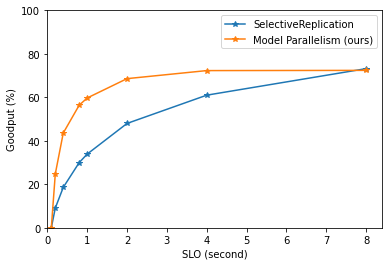

Output the plot to fig_gamma_2_short_slos_no_ilp.pdf


In [59]:
run_and_plot("gamma_2_short_slos_no_ilp")

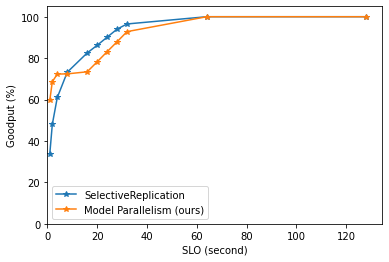

Output the plot to fig_gamma_2_long_slos_no_ilp.pdf


In [5]:
run_and_plot("gamma_2_long_slos_no_ilp")

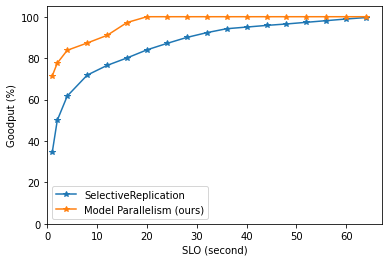

Output the plot to fig_gamma_2_long_slos_no_ilp_pipeline_overhead_1.0.pdf


In [2]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.0")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.05")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.1")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.15")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.2")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.25")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.3")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.35")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.4")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.45")

In [ ]:
run_and_plot("gamma_2_long_slos_no_ilp_pipeline_overhead_1.5")

In [ ]:
# With fixed placement and different SLOs, what changes?
# Longer SLO -> Longer queue
# Selective replication: every model has their own queue
# Pipeline: We have a global queue for all models
# With short SLO, bursty requests mean that the queue for one model can get very long
# With long SLO, 
# 
# Long SLO amortizes the burstiness.
# Running queue size.

In [ ]:
datasets = [
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.0.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.05.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.1.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.15.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.2.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.25.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.3.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.35.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.4.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.45.tsv",
    "res_gamma_2_long_slos_no_ilp_pipeline_overhead_1.5.tsv",
]
data = {}
for dataset in datasets:
    data[dataset] = read_data(dataset)
sr_data = data[datasets[0]]["sr"]
data = {"mp_" + k.split(".tsv")[0].split("_")[-1]: data[k]["mp"] for k in datasets}
data["sr"] = sr_data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_dict = {
    "mp_1.0": "#1f77b4ff",
    "mp_1.05": "#1f77b4ef",
    "mp_1.1": "#1f77b4df",
    "mp_1.15": "#1f77b4cf",
    "mp_1.2": "#1f77b4bf",
    "mp_1.25": "#1f77b4af",
    "mp_1.3": "#1f77b49f",
    "mp_1.35": "#1f77b48f",
    "mp_1.4": "#1f77b47f",
    "mp_1.45": "#1f77b46f",
    "mp_1.5": "#1f77b45f",
    "sr": "C1"
}

def plot_goodput_vs_slo_many(data, output, show):
    fig, ax = plt.subplots()
    figure_size = (4, 4)

    methods = list(data.keys())
    # methods.sort(key=lambda x: method2order(x))

    curves = []
    legends = []
    x_max = 0
    y_max = 0
    for method in methods:
        curve = data[method]
        xs, ys = zip(*curve.items())
        ys = np.array(ys) * 100
        curve = ax.plot(xs, ys, color=color_dict[method], marker='.')
        curves.append(curve[0])
        legends.append(method)

        x_max = max(x_max, *xs)
        y_max = max(y_max, *ys)

    ax.set_ylim(bottom=0, top=max(y_max * 1.05, 100))
    x_max = 64
    ax.set_xlim(left=0, right=x_max * 1.05)
    ax.set_ylabel("Goodput (%)")
    ax.set_xlabel("SLO (second)")
    ax.legend(curves, legends)

    if show:
        plt.show()

    fig.set_size_inches(figure_size)
    fig.savefig(output, bbox_inches='tight')
    print(f"Output the plot to {output}")
plot_goodput_vs_slo_many(data, "fig_pipeline_overheads.pdf", show=True)

# Sketch

In [ ]:
import pickle
from alpa_serve.profiling import ParallelConfig
from alpa_serve.placement_policy import ModelParallelismPlacement
import numpy as np

In [8]:
result = pickle.load(open("profiling_result.pkl", "rb"))

In [16]:
latency_8stages = np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 8)].latency[1])

In [18]:
latency_8stages.max() * 8

0.12776608

In [19]:
latency_1stage = np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 1)].latency[1])

In [20]:
latency_1stage

array([0.0996182])

In [21]:
0.12776608 / 0.0996182

1.2825576049356442

In [22]:
np.array(result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 4)].latency[1]).max() * 4

0.10797936

In [23]:
0.10797936 / 0.0996182

1.083932052576738

In [12]:
def compute_capability(slo, profile_result, parallel_config):
    slo = slo
    latency_mem = profile_result.para_dict.get(parallel_config, None)

    if latency_mem is None:
        return 0

    num_stages = parallel_config.pp
    max_cap = 0
    max_bs = 1
    for b, ls in latency_mem.latency.items():
        if b > max_bs:
            continue

        # slo = sum(ls) + (n-1) * max(ls)
        # so, n = ceil((slo - sum(ls)) / max(ls)) + 1
        max_cap = max(max_cap, (slo - sum(ls)) // max(ls) + 1)

    return max_cap


In [18]:
slos = [0.1, 0.2, 0.4, 0.8, 1.0, 2.0, 4.0, 8.0]
for slo in slos:
    for pp in [1, 2, 4, 8]:
        print("slo", slo, "pp", pp, compute_capability(slo, result['bert-1.3b'], ParallelConfig(1, 1, pp)))

slo 0.1 pp 1 1.0
slo 0.1 pp 2 1.0
slo 0.1 pp 4 0
slo 0.1 pp 8 0
slo 0.2 pp 1 2.0
slo 0.2 pp 2 3.0
slo 0.2 pp 4 4.0
slo 0.2 pp 8 6.0
slo 0.4 pp 1 4.0
slo 0.4 pp 2 7.0
slo 0.4 pp 4 12.0
slo 0.4 pp 8 19.0
slo 0.8 pp 1 8.0
slo 0.8 pp 2 15.0
slo 0.8 pp 4 26.0
slo 0.8 pp 8 44.0
slo 1.0 pp 1 10.0
slo 1.0 pp 2 19.0
slo 1.0 pp 4 34.0
slo 1.0 pp 8 56.0
slo 2.0 pp 1 20.0
slo 2.0 pp 2 39.0
slo 2.0 pp 4 71.0
slo 2.0 pp 8 119.0
slo 4.0 pp 1 40.0
slo 4.0 pp 2 79.0
slo 4.0 pp 4 145.0
slo 4.0 pp 8 244.0
slo 8.0 pp 1 80.0
slo 8.0 pp 2 159.0
slo 8.0 pp 4 293.0
slo 8.0 pp 8 495.0


In [ ]:
# slo 0.8 pp 1 8.0
# slo 0.8 pp 2 15.0
# slo 0.8 pp 4 26.0
# slo 0.8 pp 8 44.0
# slo 1.0 pp 1 10.0
# slo 1.0 pp 2 19.0
# slo 1.0 pp 4 34.0
# slo 1.0 pp 8 56.0

# SLO 0.8: Optimal case
# ModelParallelismPlacement([(ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]), 
#                            (ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15])])
obj_optimal = 26 * 2
obj_non_optimal = 26
# SLO 1.0: Optimal case
# ModelParallelismPlacement([(ParallelConfig(dp=1, op=1, pp=2), [0, 7, 9, 10, 11, 12, 13]), 
#                            (ParallelConfig(dp=1, op=1, pp=1), [7, 11, 12]), 
#                            (ParallelConfig(dp=1, op=1, pp=1), [2, 5, 7]), 
#                            (ParallelConfig(dp=1, op=1, pp=4), [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15])])
obj_optimal = 34.0 * 2
obj_non_optimal = 34.0

In [30]:
result['bert-1.3b'].para_dict[ParallelConfig(1, 1, 1)].weight_mem

[2838835202.8206697]

In [24]:
from alpa_serve.util import GB

In [25]:
10*GB

10737418240

In [41]:
40 / (2838835202.8206697 / GB)

15.12932942261853

In [28]:
len([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15])

15